In [20]:
#@title Imports
import torch
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import io
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_score, recall_score, f1_score
import shutil
from sklearn.model_selection import train_test_split


In [21]:
# Mount Google Drive for data retrieval and storage
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Albumentations Class
class AlbumentationsTransform:
  """A class to make Albumentations compatible with built-in torchvision Datasets.

  This class takes an Albumentations transformation as input and makes it
  behaive astorchvision Transform objects. Note that if you are using your own
  dataset, this is not needed.

  Attributes:
    transform: An Albumentations transform object.

    """
  def __init__(self, transform):
    """Initializes AlbumentationsTransform with a given PyTorch transform.

    Args:
      transform: An Albumentations transform object.
    """
    self.transform = transform

  def __call__(self, img):
    img = np.array(img)
    augmented = self.transform(image=img)
    img = augmented['image']
    return img

In [23]:
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 32
NUM_EPOCHS = 250
BEST_MODEL_PATH = '/content/drive/My Drive/best_model_mekha_7.0.pt'

In [24]:
# Augmentation pipelines for test, train and validation
train_transform = A.Compose(
    transforms=[
      A.Resize(HEIGHT, WIDTH),
      A.Normalize(mean=MEAN, std=STD),
      ToTensorV2(),
    ],
    p=1.0,
)
train_transform = AlbumentationsTransform(train_transform)


valid_test_transform = A.Compose(
    transforms=[
        A.Resize(HEIGHT, WIDTH),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ],
    p=1.0,
)
valid_test_transform = AlbumentationsTransform(valid_test_transform)

### Split the images folder to train, validation and test

In [25]:
def split_image_folder(data_folder, output_folder, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Splits images in a folder into train, validation, and test folders without organizing by class.

    Args:
        data_folder (str): Path to the folder containing images.
        output_folder (str): Path to the output folder where train, val, and test subfolders will be created.
        train_ratio (float): Proportion of images to include in the training set.
        val_ratio (float): Proportion of images to include in the validation set.
        test_ratio (float): Proportion of images to include in the test set.
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"

    # Create output directories
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(output_folder, split)
        os.makedirs(split_dir, exist_ok=True)

    # Collect all image paths
    image_paths = [os.path.join(data_folder, filename)
                   for filename in os.listdir(data_folder)
                   if filename.endswith(('.png', '.jpg', '.jpeg'))]

    # Split dataset
    train, temp = train_test_split(image_paths, test_size=(val_ratio + test_ratio), random_state=42)
    val, test = train_test_split(temp, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # Move files to respective directories
    for split, split_images in zip(['train', 'val', 'test'], [train, val, test]):
        split_dir = os.path.join(output_folder, split)
        os.makedirs(split_dir, exist_ok=True)
        for image_path in split_images:
            shutil.copy(image_path, split_dir)

    print("Dataset split completed!")
    print(f"Train: {len(train)} images")
    print(f"Validation: {len(val)} images")
    print(f"Test: {len(test)} images")

In [26]:
data_folder = "/content/drive/MyDrive/kaggle_skin_dataset"
# Folder to store train, val, test splits
output_folder = "/content/drive/MyDrive/kaggle_skin_dataset"
split_image_folder(data_folder, output_folder, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

### Dataset

In [27]:
# Custom Dataset
class SkinConditionDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        """
        Custom dataset for skin condition images.

        Args:
            data_folder (str): Path to the folder containing images.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.data_folder = data_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []


        # Parse the folder to load image paths and extract labels
        for file_name in os.listdir(data_folder):
             # Support common image formats
            if file_name.endswith(('.png', '.jpg', '.jpeg')):
                # Extract the condition name
                label = file_name.split('.')[0]
                label = label.lower()
                # only add image with condition acne, none
                self.image_paths.append(os.path.join(data_folder, file_name))
                self.labels.append(label)
        self.unique_labels = ['acne', 'carcinoma', 'eczema', 'keratosis', 'milia', 'non', 'rosacea']
        self.unique_labels.sort()
        print(self.unique_labels)
        print(len(self.unique_labels))
        # Count occurrences of each condition
        self.condition_counts = Counter(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def get_tensor_from_label(self, label):
      # Map the label to an index (integer)
      label_id = self.unique_labels.index(label)
      return torch.tensor(label_id)

    def get_label_from_tensor(self, tensor):
      label_id = tensor.item()
      return self.unique_labels[label_id]


    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, self.get_tensor_from_label(label)

    def get_condition_counts(self):
        return dict(self.condition_counts)

In [28]:
# Path to your dataset folder
data_folder = "/content/drive/MyDrive/kaggle_skin_dataset/train"

# Initialize the dataset
train_dataset = SkinConditionDataset(data_folder, transform=train_transform)

# Get the total number of images
total_images = len(train_dataset)
print(f"Total images in dataset: {total_images}")

# Get the count of each condition
condition_counts = train_dataset.get_condition_counts()
print("Number of images per condition:")
for condition, count in condition_counts.items():
    print(f"  {condition}: {count}")

['acne', 'carcinoma', 'eczema', 'keratosis', 'milia', 'non', 'rosacea']
7
Total images in dataset: 1241
Number of images per condition:
  milia: 87
  eczema: 317
  keratosis: 116
  rosacea: 219
  carcinoma: 108
  acne: 218
  non: 176


In [37]:
# Validation
data_folder = "/content/drive/MyDrive/kaggle_skin_dataset/val"
val_dataset = SkinConditionDataset(data_folder, transform=valid_test_transform)

# Get the total number of images
total_images = len(val_dataset)
print(f"Total images in dataset: {total_images}")

# Get the count of each condition
condition_counts = val_dataset.get_condition_counts()
print("Number of images per condition:")
for condition, count in condition_counts.items():
    print(f"  {condition}: {count}")

# Test
data_folder = "/content/drive/MyDrive/kaggle_skin_dataset/test"
test_dataset = SkinConditionDataset(data_folder, transform=valid_test_transform)
# Get the total number of images
total_images = len(test_dataset)
print(f"Total images in dataset: {total_images}")

# Get the count of each condition
condition_counts = test_dataset.get_condition_counts()
print("Number of images per condition:")
for condition, count in condition_counts.items():
    print(f"  {condition}: {count}")

['acne', 'carcinoma', 'eczema', 'keratosis', 'milia', 'non', 'rosacea']
7
Total images in dataset: 266
Number of images per condition:
  milia: 20
  acne: 47
  eczema: 73
  keratosis: 19
  rosacea: 40
  carcinoma: 31
  non: 36
['acne', 'carcinoma', 'eczema', 'keratosis', 'milia', 'non', 'rosacea']
7
Total images in dataset: 266
Number of images per condition:
  non: 46
  eczema: 63
  carcinoma: 20
  acne: 52
  milia: 16
  rosacea: 45
  keratosis: 24


In [35]:
# Dataloader for the train, validation and test datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def visualize_image_grid(image_label_pairs, rows, cols,  mean=MEAN, std=STD):
  """
  Visualizes a grid of images with their labels.

  Args:
    image_label_pairs: A list of tuples, where each tuple is (image, label).
    rows: The number of rows where images are shown.
    cols: The number of columns where images are shown.
  """
  if len(image_label_pairs) != rows * cols:
    raise ValueError("The number of image-label pairs must exactly match rows * cols")
  fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
  for ax, (image, label) in zip(axes.flatten(), image_label_pairs):
    image = image.permute(1, 2, 0)
    image *= torch.Tensor(std)
    image += torch.Tensor(mean)
    ax.imshow(image)
    title = train_dataset.get_label_from_tensor(label)
    ax.set_title(title)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

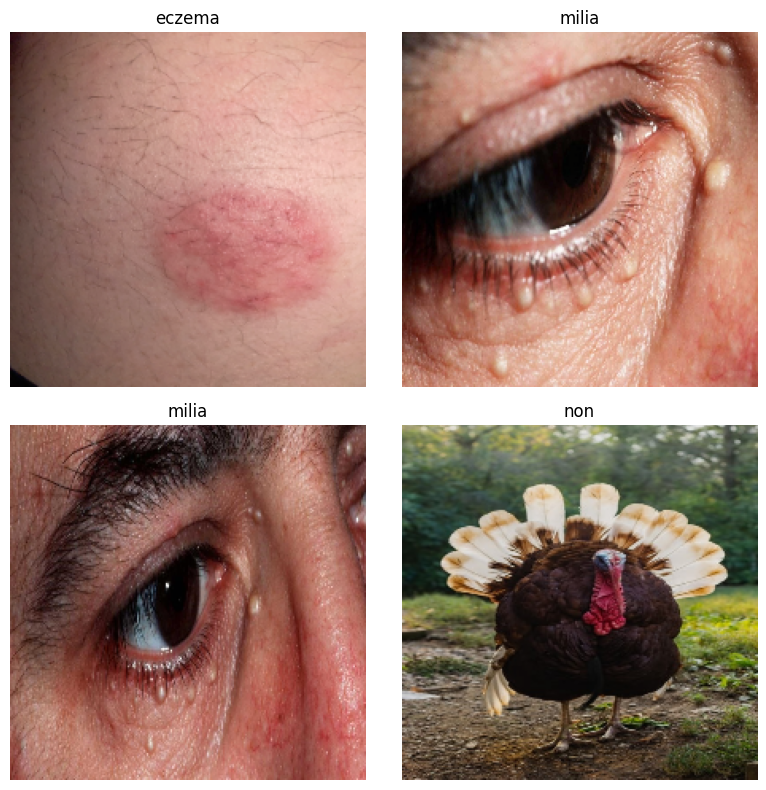

In [ ]:
rows = 2
columns = 2
data = train_dataset
indices = np.random.randint(low=0, high=len(data), size=rows*columns)
train_examples = [data[i] for i in indices]
visualize_image_grid(train_examples, rows, columns)

# Transfer  Learning with ConvNext_Small

Classifier Code: https://github.com/NadavIs56/Skin_Disease_AI/tree/main

In [31]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=7):
        super(CustomModel, self).__init__()

        # Load the pre-trained Xception model
        self.base_model = models.convnext_small(weights='IMAGENET1K_V1', pretrained=True)  # PyTorch does not have Xception; EfficientNetB7 is a close alternative

        # Freeze the base model layers
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the classifier with a custom head
        self.base_model.classifier = nn.Identity()  # Remove the default classifier

        self.global_pooling = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc1 = nn.Linear(768, 256)  # EfficientNetB7 has 2560 output features
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Extract features from the base model
        x = self.base_model.features(x)
        x = self.global_pooling(x)
        # Flatten for the fully connected layers
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.softmax(x)

        return x




In [15]:
# Instantiate the model
model = CustomModel(num_classes=7)

# Print model summary
print(model)

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:01<00:00, 176MB/s]


CustomModel(
  (base_model): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((9

In [16]:
# Set the device type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [ ]:
# Loss Function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

## Validation Loop

In [17]:
def evaluation(model, loader, criterion, device, phase='Valid'):
  """Evaluate the performance of a model on a given dataset.

  This function calculates the loss and accuracy of the model on the dataset.
    It also returns the ground truth labels and the model's predictions.

  Args:
    model (torch.nn.Module): The model to be evaluated.
    loader (torch.utils.data.DataLoader): The data loader for the dataset.
    criterion (torch.nn.modules.loss._Loss): The loss function.
    device (torch.device): The device (CPU or GPU) where computations will be performed.
    phase (str, optional): The phase of evaluation. Defaults to 'Valid'.

  Returns:
    dict: A dictionary containing the following keys:
      'loss' (float): The average loss of the model on the dataset.
      'accuracy' (float): The accuracy of the model on the dataset.
      'ground_truth' (list): The ground truth labels of the dataset.
      'predictions' (list): The model's predictions on the dataset.
    """
  model.eval()
  predictions = []
  ground_truth = []
  with torch.no_grad():
    total_loss = 0
    total  = 0
    correct = 0
    for batch_index, (images, labels) in enumerate(loader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds.cpu().numpy())
      ground_truth.extend(labels.cpu().numpy())
      correct += (preds == labels).sum().item()
    accuracy = correct / total
    loss = total_loss / total
    print(f'     {phase} Accuracy={accuracy:<10.4f}  Loss= {loss:<10.4f}')
    precision = precision_score(ground_truth, predictions, average='weighted')
    recall = recall_score(ground_truth, predictions, average='weighted')
    f1 = f1_score(ground_truth, predictions, average='weighted')

    return {'loss': loss,
            'accuracy': accuracy,
            'ground_truth': ground_truth,
            'predictions': predictions,
            'precision': precision,
            'recall': recall,
            'f1': f1}

## Training Loop

In [18]:
def training(model, train_loader, valid_loader, criterion, optimizer, device,
             epochs, best_model_path):
  """Train a model and evaluate its performance on a validation set.

  This function trains a model for a specified number of epochs and evaluates
    its performance on a validation set after each epoch. The model with the
    lowest validation loss is saved.

  Args:
    model (torch.nn.Module): The model to be trained.
    train_loader (torch.utils.data.DataLoader): The data loader for the training set.
    valid_loader (torch.utils.data.DataLoader): The data loader for the validation set.
    criterion (torch.nn.modules.loss._Loss): The loss function.
    optimizer (torch.optim.Optimizer): The optimization algorithm.
    device (torch.device): The device (CPU or GPU) where computations will be performed.
    epochs (int): The number of times the learning algorithm will work through the entire training dataset.
    best_model_path (str): The path where the best model will be saved.

  Returns:
    dict: A dictionary containing the 'loss', 'accuracy', 'ground_truth', and 'predictions'
            of the model with the lowest validation loss.
    """
  model.train()
  best_loss = torch.inf
  best_restults = None
  for epoch in range(epochs):
    total_loss = 0
    total  = 0
    correct = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      optimizer.zero_grad()
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
    accuracy = correct / total
    loss = total_loss / total
    print(f'{epoch:<4} Train Accuracy={accuracy:<10.4f}  Loss= {loss:<10.4f}')
    results = evaluation(model, valid_loader, criterion, device)
    if results['loss'] < best_loss:
      torch.save(model, best_model_path)
      best_loss = results['loss']
      best_restults = results
    print()
  return best_restults

In [ ]:
best_results = training(model, train_loader, val_loader, criterion,
                         optimizer, device, NUM_EPOCHS, BEST_MODEL_PATH)

In [19]:
# continue training
model = torch.load(BEST_MODEL_PATH)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
best_results = training(model, train_loader, val_loader, criterion,
                         optimizer, device, 5, BEST_MODEL_PATH)
print(best_results)

<ipython-input-19-11cab16a6e47>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(BEST_MODEL_PATH)


0    Train Accuracy=0.9517      Loss= 1.2344    
     Valid Accuracy=0.8759      Loss= 1.2959    

1    Train Accuracy=0.9919      Loss= 1.1763    
     Valid Accuracy=0.8722      Loss= 1.2954    

2    Train Accuracy=0.9919      Loss= 1.1743    
     Valid Accuracy=0.8835      Loss= 1.2840    

3    Train Accuracy=0.9919      Loss= 1.1738    
     Valid Accuracy=0.8947      Loss= 1.2808    

4    Train Accuracy=0.9919      Loss= 1.1736    
     Valid Accuracy=0.8872      Loss= 1.2806    

{'loss': 1.2805704622340381, 'accuracy': 0.8872180451127819, 'ground_truth': [4, 0, 2, 0, 4, 3, 6, 2, 2, 3, 1, 2, 5, 2, 1, 6, 2, 1, 1, 5, 3, 6, 0, 4, 2, 6, 0, 2, 5, 6, 3, 6, 0, 1, 3, 6, 2, 0, 2, 3, 5, 6, 2, 2, 0, 5, 1, 2, 1, 2, 5, 6, 2, 6, 2, 2, 0, 0, 2, 2, 2, 1, 2, 1, 1, 1, 1, 0, 6, 0, 0, 2, 0, 0, 2, 2, 1, 3, 2, 2, 4, 1, 0, 4, 0, 0, 6, 0, 1, 2, 5, 5, 0, 3, 1, 1, 5, 4, 0, 2, 6, 6, 3, 5, 5, 1, 2, 6, 3, 5, 6, 1, 5, 2, 2, 0, 5, 0, 1, 2, 6, 3, 4, 4, 5, 2, 0, 3, 6, 4, 2, 5, 4, 2, 5, 2, 1, 1, 5, 0, 3, 2, 0

In [32]:
# create a testing pipeline
def test_pipeline(model, test_loader, device):
  model.eval()
  total_predictions = []
  total_ground_truth = []
  with torch.no_grad():
    total = 0
    correct = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, preds = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (preds == labels).sum().item()
      total_predictions.extend(preds.cpu().numpy())
      total_ground_truth.extend(labels.cpu().numpy())
    accuracy = correct / total
    print(f'Test Accuracy={accuracy:<10.4f}')
    return accuracy, correct, total, total_predictions, total_ground_truth

<ipython-input-36-d250cd1c8621>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(BEST_MODEL_PATH)


cuda
Test Accuracy=0.6000    
[3, 2, 4, 2, 0, 2, 2, 2, 3, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


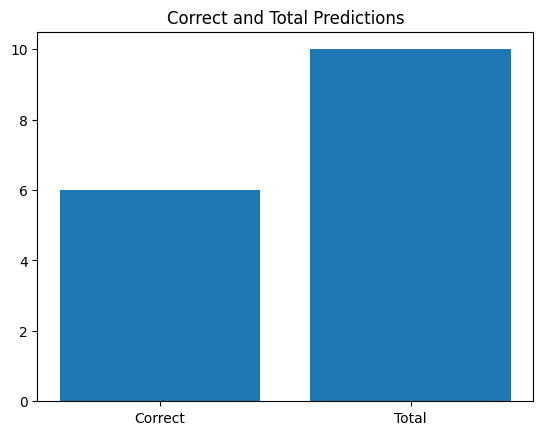

In [36]:
model = torch.load(BEST_MODEL_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)
accuracy, correct, total, total_predictions, total_ground_truth = test_pipeline(model, test_loader, device)
# plot correct and total
print(total_predictions)
print(total_ground_truth)
plt.bar(['Correct', 'Total'], [correct, total])
plt.title('Correct and Total Predictions')
plt.show()